In [1]:
# core
import numpy as np
import pandas as pd

# eda
from pandas_profiling import ProfileReport

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

# try altair
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## What's the best time to get married in NYC?

### Data
NYC / Brooklyn pop from 2018 Census:
https://usa.ipums.org/usa-action/extract_requests/summary

See key at: https://usa.ipums.org/usa-action/downloads/extract_files/usa_00004.cbk

### Approach
1. Take married sub-population and look at age difference with spouse.
2. Take 90th and 10th percentile age difference as addressable partner age
3. Multiply those bounds by non-married populations in those age ranges

### Assumptions
* Marriage preferences stay constant over time (we know this is false and trending farther away)
* Marriage age preferences among currently married couples is consistent with preferences among non-married couples

### Tech
We should use this opportunity to try out the latest data science tech, notably:
* pandas_profiling
    * Pros: simplest way to standardize EDA (pretty much just a one-liner)
    * Cons: Can take a while to run
* great_expectations
    * Pros: "suped-up" version of pandas_profiling, workflow is actually quite nice
    * Cons: need to know what you want out of the data. Could be a really great workflow for longer-lived projects
* altair
    * Pros: smart defaults, intuitive API, handles all properties of a chart (i.e. no need for matplotlib!), great documentation
    * Cons: nothing really beats the verbosity of df.plot() when it comes to EDA, seaborn built-in uncertainty intervals :)

## Profile IPUMS data

In [2]:
df_raw = pd.read_csv('./data/nyc_extract.csv')
df_raw.head()

YEAR  SAMPLE  SERIAL       CBSERIAL  HHWT        CLUSTER  STATEFIP  \
0  2018  201801  827850  2018010000012   145  2018008278501        36   
1  2018  201801  827859  2018010000136   104  2018008278591        36   
2  2018  201801  827861  2018010000186     5  2018008278611        36   
3  2018  201801  827867  2018010000325   166  2018008278671        36   
4  2018  201801  827868  2018010000327   246  2018008278681        36   

   COUNTYFIP  CITY  CITYPOP  ...  AGE  MARST  MARRNO  YRMARR  RACE  RACED  \
0         61  4610    83987  ...   26      6       0       0     1    100   
1          5  4610    83987  ...   56      6       0       0     1    100   
2         61  4610    83987  ...   50      2       1    2016     2    200   
3         47  4610    83987  ...   46      6       0       0     1    100   
4         47  4610    83987  ...   40      6       0       0     1    100   

   INCTOT  FTOTINC  AGE_SP  RACE_SP  
0    5200  9999999     NaN      NaN  
1    9000  9999999     NaN      NaN  
2       0  9999999     NaN      NaN  
3   25000  9999999     NaN      NaN  
4    1700  9999999     NaN      NaN  

[5 rows x 26 columns]

In [3]:
# Pandas profile (takes a few seconds to run so commented out)
# profile = ProfileReport(df_raw, minimal=True)
# profile.to_file(output_file='profiles/nyc_extract_profile.html')

Clean up raw data into a 'derived' dataframe.

* Filter out same sex marraiges
* Bucket values
* Add cols `years_older_than_spouse` and `log_income_multiplier`
* Clean up col names

In [4]:
cols = ['sex','AGE', 'marst', 'AGE_SP', 'years_older_than_sp', 'INCTOT', 'FTOTINC', 'log_income_multiplier']
df_derived = df_raw.query('SSMC == 0').assign(
    sex=df_raw['SEX'].apply(lambda row: 'female' if row == 2 else 'male'),
    marst = df_raw['MARST'].apply(lambda row: 'married' if row in (1,2) else 'unmarried'),
    years_older_than_sp=df_raw['AGE'] - df_raw['AGE_SP'],
    log_income_multiplier=np.log(df_raw['FTOTINC'] / df_raw['INCTOT'])
)[cols]

df_derived.columns = [col.lower() for col in df_derived.columns]
df_derived.head()

/Users/kennethning/repos/marriage/env/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kennethning/repos/marriage/env/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


sex  age      marst  age_sp  years_older_than_sp  inctot  ftotinc  \
0  female   26  unmarried     NaN                  NaN    5200  9999999   
1  female   56  unmarried     NaN                  NaN    9000  9999999   
2    male   50    married     NaN                  NaN       0  9999999   
3  female   46  unmarried     NaN                  NaN   25000  9999999   
4    male   40  unmarried     NaN                  NaN    1700  9999999   

   log_income_multiplier  
0               7.561682  
1               7.013116  
2                    inf  
3               5.991464  
4               8.679712

## Spousal Age Difference


In [5]:
# plot age difference spread as a function of spousal age
male_chart = alt.Chart(df_derived.query('sex == "male" and marst == "married" and age > 20 and age < 65'), title='Age difference of NYC married couples (for men)').mark_boxplot().encode(
    alt.X('age',
          scale=alt.Scale(domain=(25,60)),
          axis=alt.Axis(title='Age of husband')
    ),
    alt.Y('years_older_than_sp',
          axis=alt.Axis(title='Years older than wife')
         )
).properties(
    width=800,
    height=400
)

female_chart = alt.Chart(df_derived.query('sex == "female" and marst == "married" and age > 20 and age < 65'), title='Age difference of NYC married couples (for women)').mark_boxplot().encode(
    alt.X('age',
          scale=alt.Scale(domain=(25,60)),
          axis=alt.Axis(title='Age of wife')
    ),
    alt.Y('years_older_than_sp',
          axis=alt.Axis(title='Years older than husband')
         )
).properties(
    width=800,
    height=400
)

alt.vconcat(male_chart, female_chart)

alt.VConcatChart(...)

As men increase in age, they are able to date a wider range of women (represented by the size of the interquartile range of the box plot.

On the other hand, as women age, they marry the same range of ages and are almost always younger.

## How much is marriage age difference attributable to income?

In [6]:
alt.Chart(df_derived.query("sex == 'female' and marst == 'married'"), title='NYC married females').mark_circle(size=60).encode(
    x=alt.X('years_older_than_sp', title='Years older than husband'),
    y=alt.Y('log_income_multiplier', title='Income multiplier (log)'),
).configure_mark(
    opacity=0.2
)

alt.Chart(...)

Doesn't seem to be a strong correlation between age difference and income.

## NYC % unmarried by age

In [7]:
# map colors to gender
color_domain = ['male', 'female']
range_domain = ['#89cff0', 'pink']

In [8]:
unmarried = df_derived.query("marst == 'unmarried'")

In [9]:
# get % of unmarried males by age
men_age_dist = (unmarried.query("sex == 'male'")['age']
                  .value_counts()
                  .to_frame()
              ) / len(unmarried.query("sex == 'male'"))
men_age_dist['sex'] = 'male'
men_age_dist.head()

age   sex
28  0.044382  male
25  0.044289  male
24  0.043263  male
26  0.042984  male
27  0.042145  male

In [10]:
# get % of unmarried females by age
wom_age_dist = (unmarried.query("sex == 'female'")['age']
                  .value_counts()
                  .to_frame()
              ) / len(unmarried.query("sex == 'female'"))
wom_age_dist['sex'] = 'female'
wom_age_dist.head()

age     sex
26  0.040773  female
24  0.040382  female
25  0.040304  female
28  0.037486  female
30  0.037095  female

In [11]:
# merge female and male vertically for graphing purposes
merged_age_dist = pd.concat([men_age_dist.reset_index(), wom_age_dist.reset_index()], ignore_index=True)
merged_age_dist.head()

index       age   sex
0     28  0.044382  male
1     25  0.044289  male
2     24  0.043263  male
3     26  0.042984  male
4     27  0.042145  male

In [12]:
alt.Chart(merged_age_dist, title='% NYC unmarried').mark_line().encode(
    x=alt.X('index', title='Age'),
    y=alt.Y('age', axis=alt.Axis(format='%'), title=''),
    color=alt.Color(
        'sex',
        scale=alt.Scale(domain=color_domain, range=range_domain),
        legend=alt.Legend(title='Sex'))
)

alt.Chart(...)

We see here that addressable size for both genders takes a pretty dramatic turn in the 30s (though men stay unmarried slightly longer)

Fun spike at 40 (midlife crisis??)

## Unmarried Pop by Age
Extrapolate out unmarried population by age by taking the distribution of ages in our sample multiplied by NYC's population split by m/f

In [13]:
nyc_city_pop = df_raw['CITYPOP'].loc[0] * 100  # city pop is stored in hundreds in the original data
nyc_city_pop

8398700

In [14]:
gender_split = df_raw['SEX'].value_counts() / len(df_raw)
gender_split

2    0.529702
1    0.470298
Name: SEX, dtype: float64

In [15]:
nyc_female_pop = nyc_city_pop * gender_split.loc[2]
nyc_male_pop = nyc_city_pop * gender_split.loc[1]
print(f"Female pop: {nyc_female_pop:.2f}")
print(f"Male pop: {nyc_male_pop:.2f}")

Female pop: 4448810.66
Male pop: 3949889.34


In [16]:
wom_age_dist.head()

age     sex
26  0.040773  female
24  0.040382  female
25  0.040304  female
28  0.037486  female
30  0.037095  female

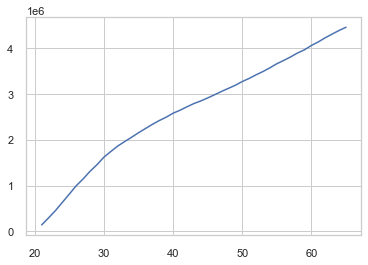

In [17]:
# get estimated population sizes for nyc unmarried females by age
fpop_size_cumsum = (wom_age_dist['age'] * nyc_female_pop).sort_index().cumsum()
fpop_size_cumsum.plot()

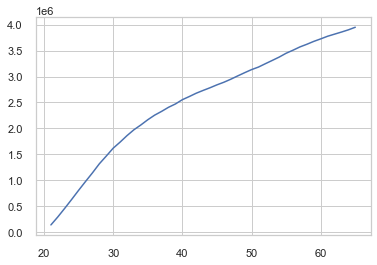

In [18]:
# get estimated population sizes for nyc unmarried females by age
mpop_size_cumsum = (men_age_dist['age'] * nyc_male_pop).sort_index().cumsum()
mpop_size_cumsum.plot()

## Multiply the two distributions to get marriage pool size
i.e. Unmarried counts by age * Likely age range of partner

In [19]:
def build_age_df(gender='male'):
    '''
    Take in a df with a range index and populate cols for possible partner ages (using interquartile range as upper/lower bound)
    '''

    df_ages = pd.DataFrame(index=pd.RangeIndex(25, 58))
    
    min_partner_ages = []
    max_partner_ages = []
    median_partner_ages = []

    for i in df_ages.index:
        age_diffs = df_derived.query("sex == @gender and marst == 'married' and age == @i")['years_older_than_sp']
        min_partner_age = i - age_diffs.quantile(0.75)
        max_partner_age = i - age_diffs.quantile(0.25)
        median_partner_age = i - age_diffs.quantile(0.5)

        min_partner_ages.append(min_partner_age)
        max_partner_ages.append(max_partner_age)
        median_partner_ages.append(median_partner_age)
        
    
    df_ages['sex'] = gender
    df_ages['partner_min_age'] = min_partner_ages
    df_ages['partner_max_age'] = max_partner_ages
    df_ages['partner_median_age'] = median_partner_ages

    df_ages.head()
    
    return df_ages

In [20]:
def get_mates(gender='male'):
    '''
    Multiply age difference distribution with unmarried population distribution
    '''
    sizes = []
    df_ages = build_age_df(gender)
    for i in df_ages.index:
        max_age = int(df_ages.loc[i]['partner_max_age'])
        min_age = int(df_ages.loc[i]['partner_min_age'])

        if gender == 'male':
            size = fpop_size_cumsum.loc[max_age] - fpop_size_cumsum.loc[min_age]
            sizes.append(size)
        else:
            size = mpop_size_cumsum.loc[max_age] - mpop_size_cumsum.loc[min_age]
            sizes.append(size)

    df_ages['num_potential_mates'] = sizes
    return df_ages
    

In [21]:
build_age_df('male').head()

sex  partner_min_age  partner_max_age  partner_median_age
25  male             24.0             26.0                25.0
26  male             25.0             27.0                26.0
27  male             26.0             28.0                27.0
28  male             26.0             30.0                27.0
29  male             27.0             30.0                29.0

In [22]:
get_mates('female').head()

sex  partner_min_age  partner_max_age  partner_median_age  \
25  female             26.0             30.0                28.0   
26  female             26.0             31.0                28.0   
27  female             27.0             31.0                28.0   
28  female             28.0             34.0                30.0   
29  female             29.0             34.0                31.0   

    num_potential_mates  
25        642294.360024  
26        759409.960074  
27        592943.761260  
28        747993.030509  
29        599572.946169

In [23]:
# calc rolling 5-day averages (center window)
fdf_rolling = get_mates('female')['num_potential_mates'].rolling(5, center=True).mean().reset_index().assign(sex='female')
mdf_rolling = get_mates('male')['num_potential_mates'].rolling(5, center=True).mean().reset_index().assign(sex='male')
mdf_rolling.head()

index  num_potential_mates   sex
0     25                  NaN  male
1     26                  NaN  male
2     27        420857.906106  male
3     28        434645.110839  male
4     29        449824.962515  male

In [24]:
merged_df_ages = pd.concat([fdf_rolling, mdf_rolling], ignore_index=True)
merged_df_ages.head()

index  num_potential_mates     sex
0     25                  NaN  female
1     26                  NaN  female
2     27        668442.811607  female
3     28        649586.463423  female
4     29        601709.016862  female

In [25]:
alt.Chart(merged_df_ages, title='Pool size of potential spouses').mark_line().encode(
    x=alt.X('index', title='Age'),
    y=alt.Y('num_potential_mates', title=''),
    color=alt.Color(
        'sex',
        scale=alt.Scale(domain=color_domain, range=range_domain),
        legend=alt.Legend(title='Sex')
    )
)

alt.Chart(...)

While 30 seems like the peak type to get married as a young man, this quickly falls as your early 30s start. This lines up generally well with the distribution of unmarried women by age, which starts to really fall into the 30s. For young men in their early 30s their addressable spousal age bracket doesn't grow fast enough to make up for this loss of women leaving the pool.

However, we see an aggressive rebound starting in the back half of the 30s, well into the 40s and peaking interestingly in the early 50s. A few hypotheses:
* The unmarried female population stabilizes at around 40, as the first wave of divorces / separations begin. Combined with the fact that as men age they can marry an increasingly larger age bracket, the curve starts to recover.

Lastly, this is a snpahost in time. I am 28 years old today, and by the time I hit 30, this curve will likely continue to shifting to the right as younger generations increasingly delay life events like marriage. So for us late 20s or so men, we're really riding the wave right now and that first big fall in potential partners may never come for us :).

As expected for women, potential partners monotonically decreases over time. Unfair!